In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.2-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop2.7"
import findspark
findspark.init()

spark-3.0.2-bin-hadoop2.7/
spark-3.0.2-bin-hadoop2.7/R/
spark-3.0.2-bin-hadoop2.7/R/lib/
spark-3.0.2-bin-hadoop2.7/R/lib/sparkr.zip
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/worker/
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/worker/worker.R
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/worker/daemon.R
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/tests/
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/tests/testthat/
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/tests/testthat/test_basic.R
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/profile/
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/profile/shell.R
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/profile/general.R
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/doc/
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/doc/sparkr-vignettes.html
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/doc/sparkr-vignettes.Rmd
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/doc/sparkr-vignettes.R
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/doc/index.html
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/R/
spark-3.0.2-

In [3]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

spark = SparkSession.builder.getOrCreate()

customer = spark.read.option("inferSchema", "true").csv("Customer.csv", header = True)
jacket = spark.read.option("inferSchema", "true").csv("Jacket.csv", header = True)
jacketType = spark.read.option("inferSchema", "true").csv("JacketType.csv", header = True)
staff = spark.read.option("inferSchema", "true").csv("Staff.csv", header = True)
tHeader = spark.read.option("inferSchema", "true").csv("HeaderTransaction.csv", header = True)
tDetail = spark.read.option("inferSchema", "true").csv("DetailTransaction.csv", header = True)

customer.registerTempTable("Customer")
jacket.registerTempTable("Jacket")
jacketType.registerTempTable("JacketType")
staff.registerTempTable("Staff")
tHeader.registerTempTable("HeaderTransaction")
tDetail.registerTempTable("DetailTransaction")

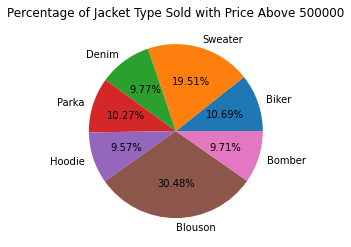

In [126]:
result1 = spark.sql("""
    SELECT 
     JacketTypeName, SUM(Quantity) AS Sold
    FROM HeaderTransaction ht 
    JOIN DetailTransaction dt ON ht.TransactionId = Dt.TransactionId
    JOIN Jacket j ON dt.JacketId = j.JacketId
    JOIN JacketType jt ON j.JacketTypeId = jt.JacketTypeId
    WHERE Price > 500000
    GROUP BY JacketTypeName
""")

result1 = result1.toPandas()
plt.title("Percentage of Jacket Type Sold with Price Above 500000")
plt.pie(result1["Sold"], labels = result1["JacketTypeName"], autopct="%.2f%%")
plt.show()

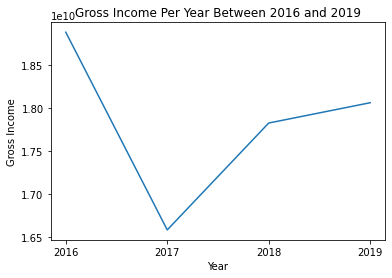

In [118]:
result2 = spark.sql("""
    SELECT 
    YEAR(TransactionDate) AS Year, SUM(Quantity*Price) AS GrossIncome
    FROM HeaderTransaction ht 
    JOIN DetailTransaction dt ON ht.TransactionId = Dt.TransactionId
    JOIN Jacket j ON dt.JacketId = j.JacketId
    WHERE YEAR(TransactionDate) BETWEEN 2016 AND 2019
    GROUP BY YEAR(TransactionDate)
    ORDER BY YEAR(TransactionDate) ASC
    """)

result2 = result2.toPandas()
plt.plot(result2["GrossIncome"])
plt.title("Gross Income Per Year Between 2016 and 2019")
plt.xticks(range(len(result2["Year"])), result2["Year"])
plt.xlabel("Year")
plt.ylabel("Gross Income")
plt.show()

+-------------+---------+
|JacketOrdered|Frequency|
+-------------+---------+
|         High|        3|
|          Low|        4|
|       Medium|        5|
+-------------+---------+



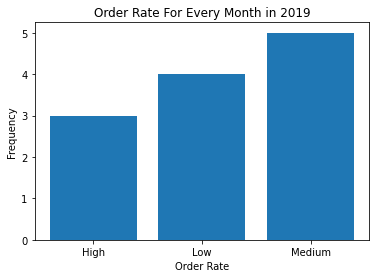

In [117]:
result3 = spark.sql("""
  SELECT 
    JacketOrdered, COUNT(*) AS Frequency
  FROM(
    SELECT 
        MONTH(TransactionDate) AS Month,
          CASE
            WHEN SUM(Quantity)  > 4000  THEN 'High'
            WHEN SUM(Quantity) BETWEEN 2501 AND 4000 THEN 'Medium'
            WHEN SUM(Quantity) <= 2500 THEN 'Low'
          END AS JacketOrdered
         FROM HeaderTransaction ht 
         JOIN DetailTransaction dt ON ht.TransactionId = dt.TransactionId
         JOIN Jacket j ON dt.JacketId = j.JacketId
        WHERE YEAR(TransactionDate) = 2019
        GROUP BY MONTH(TransactionDate)
      ) AS X
      GROUP BY JacketOrdered
      """)


result3.show()
result3 = result3.toPandas()
plt.bar(result3["JacketOrdered"], result3["Frequency"])
plt.xlabel("Order Rate")
plt.ylabel("Frequency")
plt.title("Order Rate For Every Month in 2019")
plt.show()

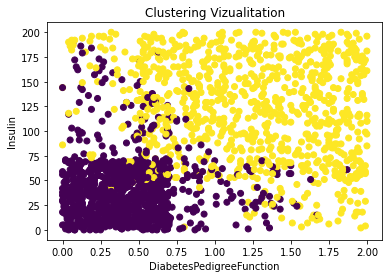

Accuracy: 91.01479915433404%


In [119]:
from pyspark.sql.functions import when
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import BinaryClassificationEvaluator

spark = SparkSession.builder.getOrCreate()
training = spark.read.option("inferSchema", "true").csv("Train.csv", header = True)
testing = spark.read.option("inferSchema", "true").csv("Test.csv", header = True)


training = training.select("DiabetesPedigreeFunction", "Insulin", "Glucose")
training = training.na.drop()

# training = training.withColumn(
#     "SugarInTake/day",
#     when(training["SugarInTake/day"] == "Low", 0)
#       .when(training["SugarInTake/day"] == "Medium", 1)
#       .otherwise(2)
# )

# training = training.withColumn(
#     "LowerBackPain",
#     when(training["LowerBackPain"] == "No", 0)
#       .otherwise(1)
# )

cols = training.columns

training = VectorAssembler(inputCols = cols, outputCol="assembled").transform(training)
scaler = StandardScaler(inputCol="assembled", outputCol="features")

training = scaler.fit(training).transform(training)

testing = testing.select("DiabetesPedigreeFunction", "Insulin", "Glucose", "Outcome")
testing = testing.na.drop()

# testing = testing.withColumn(
#     "SugarInTake/day",
#     when(testing["SugarInTake/day"] == "Low", 0)
#       .when(testing["SugarInTake/day"] == "Medium", 1)
#       .otherwise(2)
# )

# testing = testing.withColumn(
#     "LowerBackPain",
#     when(testing["LowerBackPain"] == "No", 0)
#       .otherwise(1)
# )


testing = testing.withColumn(
    "Outcome",
    when(testing["Outcome"] == "No", 0)
      .otherwise(1)
)

cols = testing.columns
cols.remove("Outcome")

testing = VectorAssembler(inputCols = cols, outputCol="assembled").transform(testing)
scaler = StandardScaler(inputCol="assembled", outputCol="features")

testing = scaler.fit(testing).transform(testing)

kmeans = KMeans(k=2)
model = kmeans.fit(training)
predictions = model.transform(testing)

predictions = predictions.toPandas()
plt.scatter(
   predictions["DiabetesPedigreeFunction"],
   predictions["Insulin"],
    c =predictions["prediction"]
)
plt.title("Clustering Vizualitation")
plt.xlabel("DiabetesPedigreeFunction")
plt.ylabel("Insulin")
plt.show()

c = 0
for idx, row in predictions.iterrows():
  if row["Outcome"] == row["prediction"]:
    c += 1

acc = c/len(predictions) * 100
print(f'Accuracy: {acc}%')

